# Hypothesis: Are digitised practices causing more failures?

## Hypothesis

We believe that practices undergoing Lloyd Gerge digitisation have an increased failure rate. 
We will know this to be true when we look at their data for the last three months, and see that either their failures have increased, or that in general their failures are higher than average.

## Context

From the months of May-Aug 2021, we see a steady increase of TPP-->EMIS Large message general failures. A general hypothesis is that this is due to record sizes increasing, which could be due to Lloyd George digitisation. This has prompted a more general hypothesis to identify whether digitisation is impacting failure rates. 

## Scope

- Generate a transfer outcomes table for each of the below CCGs split down for May, June, July:
    - Sunderland
    - Fylde and Wyre
    - Chorley and South Ribble 
    - Blackpool
    - Birmingham and Solihull 
- Show technical failure rate for each month, for each practice in the CCG
- Separate out outcomes for transfers in, and transfers out
- Do this for practices as a sender and as a requester

In [1]:
import pandas as pd
import numpy as np
import paths
from data.practice_metadata import read_asid_metadata

In [2]:
asid_lookup=read_asid_metadata("prm-gp2gp-ods-metadata-preprod", "v2/2021/8/organisationMetadata.json")

transfer_file_location = "s3://prm-gp2gp-transfer-data-preprod/v4/"

transfer_files = [
    "2021/5/transfers.parquet",
    "2021/6/transfers.parquet",
    "2021/7/transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]

transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

transfers = transfers_raw\
    .join(asid_lookup.add_prefix("requesting_"), on="requesting_practice_asid", how="left")\
    .join(asid_lookup.add_prefix("sending_"), on="sending_practice_asid", how="left")\

transfers['month']=transfers['date_requested'].dt.to_period('M')

In [3]:
def generate_monthly_outcome_breakdown(transfers, columns):
    total_transfers = (
        transfers
            .groupby(columns)
            .size()
            .to_frame("Total Transfers")
    )
    
    transfer_outcomes=pd.pivot_table(
        transfers,
        index=columns,
        columns=["status"],
        aggfunc='size'
    )
    

    transfer_outcomes_pc = (
        transfer_outcomes
            .div(total_transfers["Total Transfers"],axis=0)
            .multiply(100)
            .round(2)
            .add_suffix(" %")
    )
    
    failed_transfers = (
        transfers
            .assign(failed_transfer=transfers["status"] != "INTEGRATED_ON_TIME")
            .groupby(columns)
            .agg({'failed_transfer': 'sum'})
            .rename(columns={'failed_transfer': 'ALL_FAILURE'})
    )
    
    failed_transfers_pc = (
        failed_transfers
            .div(total_transfers["Total Transfers"],axis=0)
            .multiply(100)
            .round(2)
            .add_suffix(" %")
    )
    
    

    return pd.concat([
        total_transfers,
        transfer_outcomes,
        failed_transfers,
        transfer_outcomes_pc,
        failed_transfers_pc,
    ],axis=1).fillna(0)


## Generate national transfer outcomes

In [4]:
national_metrics_monthly=generate_monthly_outcome_breakdown(transfers, ["month"])
national_metrics_monthly

,Total Transfers,INTEGRATED_ON_TIME,PROCESS_FAILURE,TECHNICAL_FAILURE,UNCLASSIFIED_FAILURE,ALL_FAILURE,INTEGRATED_ON_TIME %,PROCESS_FAILURE %,TECHNICAL_FAILURE %,UNCLASSIFIED_FAILURE %,ALL_FAILURE %
month,,,,,,,,,,,
2021-05,219973,193033,17113,9376,451,26940,87.75,7.78,4.26,0.21,12.25
2021-06,248942,219565,19818,9103,456,29377,88.20,7.96,3.66,0.18,11.80
2021-07,227805,196642,19745,10881,537,31163,86.32,8.67,4.78,0.24,13.68


## Generate digitised CCG transfer outcomes

In [5]:
ccgs_to_investigate = [
    "NHS SUNDERLAND CCG",
    'NHS FYLDE AND WYRE CCG',
    'NHS CHORLEY AND SOUTH RIBBLE CCG',
    'NHS BLACKPOOL CCG',
    'NHS BIRMINGHAM AND SOLIHULL CCG'
]
is_requesting_ccg_of_interest = transfers.requesting_ccg_name.isin(ccgs_to_investigate)
is_sending_ccg_of_interest = transfers.sending_ccg_name.isin(ccgs_to_investigate)

requesting_transfers_of_interest = transfers[is_requesting_ccg_of_interest]
sending_transfers_of_interest = transfers[is_sending_ccg_of_interest]

### Requesting CCGs (Digitised)

In [6]:
requesting_ccgs_monthly=generate_monthly_outcome_breakdown(
    transfers=requesting_transfers_of_interest,
    columns=["requesting_ccg_name", "month"]
)
requesting_ccgs_monthly

Total Transfers  INTEGRATED_ON_TIME  \
requesting_ccg_name              month                                          
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05             5063              4089.0   
                                 2021-06             5927              5164.0   
                                 2021-07             5254              4426.0   
NHS BLACKPOOL CCG                2021-05              926               890.0   
                                 2021-06             1130              1095.0   
                                 2021-07              958               908.0   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05              807               735.0   
                                 2021-06              927               848.0   
                                 2021-07              861               773.0   
NHS FYLDE AND WYRE CCG           2021-05              909               771.0   
                                 2021-06             1008               860.0   
                                 2021-07             1028               883.0   
NHS SUNDERLAND CCG               2021-05              931               860.0   
                                 2021-06             1066              1008.0   
                                 2021-07              895               841.0   

                                          PROCESS_FAILURE  TECHNICAL_FAILURE  \
requesting_ccg_name              month                                         
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05            720.0              244.0   
                                 2021-06            533.0              222.0   
                                 2021-07            572.0              244.0   
NHS BLACKPOOL CCG                2021-05              4.0               30.0   
                                 2021-06              8.0               24.0   
                                 2021-07              9.0               41.0   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05             49.0               21.0   
                                 2021-06             50.0               28.0   
                                 2021-07             54.0               33.0   
NHS FYLDE AND WYRE CCG           2021-05             84.0               45.0   
                                 2021-06            113.0               31.0   
                                 2021-07             94.0               50.0   
NHS SUNDERLAND CCG               2021-05             30.0               40.0   
                                 2021-06             26.0               32.0   
                                 2021-07             22.0               32.0   

                                          UNCLASSIFIED_FAILURE  ALL_FAILURE  \
requesting_ccg_name              month                                        
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05                  10.0          974   
                                 2021-06                   8.0          763   
                                 2021-07                  12.0          828   
NHS BLACKPOOL CCG                2021-05                   2.0           36   
                                 2021-06                   3.0           35   
                                 2021-07                   0.0           50   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05                   2.0           72   
                                 2021-06                   1.0           79   
                                 2021-07                   1.0           88   
NHS FYLDE AND WYRE CCG           2021-05                   9.0          138   
                                 2021-06                   4.0          148   
                                 2021-07                   1.0          145   
NHS SUNDERLAND CCG               2021-05                   1.0           71   
                                 2021-06                   0.0           58   
                                 2021-0

### Sending CCGs (Digitised)

In [7]:
sending_ccgs_monthly=generate_monthly_outcome_breakdown(
    transfers=sending_transfers_of_interest,
    columns=["sending_ccg_name", "month"]
)
sending_ccgs_monthly

Total Transfers  INTEGRATED_ON_TIME  \
sending_ccg_name                 month                                          
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05             5528              4565.0   
                                 2021-06             6578              5637.0   
                                 2021-07             5898              4922.0   
NHS BLACKPOOL CCG                2021-05              918               870.0   
                                 2021-06             1165              1086.0   
                                 2021-07              967               897.0   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05              735               667.0   
                                 2021-06              843               772.0   
                                 2021-07              759               680.0   
NHS FYLDE AND WYRE CCG           2021-05              600               544.0   
                                 2021-06              655               610.0   
                                 2021-07              643               563.0   
NHS SUNDERLAND CCG               2021-05              892               820.0   
                                 2021-06             1038               979.0   
                                 2021-07              937               861.0   

                                          PROCESS_FAILURE  TECHNICAL_FAILURE  \
sending_ccg_name                 month                                         
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05            700.0              251.0   
                                 2021-06            694.0              237.0   
                                 2021-07            685.0              283.0   
NHS BLACKPOOL CCG                2021-05             24.0               21.0   
                                 2021-06             49.0               27.0   
                                 2021-07             33.0               37.0   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05             51.0               16.0   
                                 2021-06             51.0               17.0   
                                 2021-07             55.0               22.0   
NHS FYLDE AND WYRE CCG           2021-05             35.0               18.0   
                                 2021-06             33.0               11.0   
                                 2021-07             55.0               25.0   
NHS SUNDERLAND CCG               2021-05             46.0               26.0   
                                 2021-06             36.0               20.0   
                                 2021-07             45.0               28.0   

                                          UNCLASSIFIED_FAILURE  ALL_FAILURE  \
sending_ccg_name                 month                                        
NHS BIRMINGHAM AND SOLIHULL CCG  2021-05                  12.0          963   
                                 2021-06                  10.0          941   
                                 2021-07                   8.0          976   
NHS BLACKPOOL CCG                2021-05                   3.0           48   
                                 2021-06                   3.0           79   
                                 2021-07                   0.0           70   
NHS CHORLEY AND SOUTH RIBBLE CCG 2021-05                   1.0           68   
                                 2021-06                   3.0           71   
                                 2021-07                   2.0           79   
NHS FYLDE AND WYRE CCG           2021-05                   3.0           56   
                                 2021-06                   1.0           45   
                                 2021-07                   0.0           80   
NHS SUNDERLAND CCG               2021-05                   0.0           72   
                                 2021-06                   3.0           59   
                                 2021-0

### Requesting practices (digitised)

In [8]:
requesting_practices_monthly=generate_monthly_outcome_breakdown(
    transfers=requesting_transfers_of_interest,
    columns=["requesting_ccg_name", "requesting_practice_name", "requesting_practice_ods_code", "requesting_supplier", "month"]
)
requesting_practices_monthly

Total Transfers  \
requesting_ccg_name             requesting_practice_name            requesting_practice_ods_code requesting_supplier month                      
NHS BIRMINGHAM AND SOLIHULL CCG ACOCKS GREEN MEDICAL CENTRE         M85736                       EMIS                2021-05               59   
                                                                                                                     2021-06               81   
                                                                                                                     2021-07               59   
                                AL-SHAFA MEDICAL CENTRE             M85123                       EMIS                2021-05               29   
                                                                                                                     2021-06               31   
...                                                                                                                                       ...   
NHS SUNDERLAND CCG              WEARSIDE MEDICAL PRACTICE - PALLION A89006                       EMIS                2021-06               23   
                                                                                                                     2021-07               10   
                                WESTBOURNE MEDICAL GROUP            A89030                       EMIS                2021-05               23   
                                                                                                                     2021-06               33   
                                                                                                                     2021-07               24   

                                                                                                                              INTEGRATED_ON_TIME  \
requesting_ccg_name             requesting_practice_name            requesting_practice_ods_code requesting_supplier month                         
NHS BIRMINGHAM AND SOLIHULL CCG ACOCKS GREEN MEDICAL CENTRE         M85736                       EMIS                2021-05                 1.0   
                                                                                                                     2021-06                 0.0   
                                                                                                                     2021-07                13.0   
                                AL-SHAFA MEDICAL CENTRE             M85123                       EMIS                2021-05                28.0   
                                                                                                                     2021-06                29.0   
...                                                                                                                                          ...   
NHS SUNDERLAND CCG              WEARSIDE MEDICAL PRACTICE - PALLION A89006                       EMIS                2021-06                22.0   
                                                                                                                     2021-07                10.0   
                                WESTBOURNE MEDICAL GROUP            A89030                       EMIS                2021-05                22.0   
                                                                                                                     2021-06                32.0   
                                                                                                                     2021-07                22.0   

                                                                                                                              PROCESS_FAILURE  \
requesting_ccg_name             requesting_practice_name            requesting_practice_ods_code requesting_supplier month                      
NHS BIRMINGHAM AND SOLIHU

### Sending practices (digitised)

In [9]:
sending_practices_monthly=generate_monthly_outcome_breakdown(
    transfers=sending_transfers_of_interest,
    columns=["sending_ccg_name", "sending_practice_name", "sending_practice_ods_code", "sending_supplier", "month"]
)
sending_practices_monthly

Total Transfers  \
sending_ccg_name                sending_practice_name               sending_practice_ods_code sending_supplier month                      
NHS BIRMINGHAM AND SOLIHULL CCG ACOCKS GREEN MEDICAL CENTRE         M85736                    EMIS             2021-05               54   
                                                                                                               2021-06               44   
                                                                                                               2021-07               37   
                                AL-SHAFA MEDICAL CENTRE             M85123                    EMIS             2021-05               15   
                                                                                                               2021-06               24   
...                                                                                                                                 ...   
NHS SUNDERLAND CCG              WEARSIDE MEDICAL PRACTICE - PALLION A89006                    EMIS             2021-06               31   
                                                                                                               2021-07               35   
                                WESTBOURNE MEDICAL GROUP            A89030                    EMIS             2021-05               14   
                                                                                                               2021-06               13   
                                                                                                               2021-07               18   

                                                                                                                        INTEGRATED_ON_TIME  \
sending_ccg_name                sending_practice_name               sending_practice_ods_code sending_supplier month                         
NHS BIRMINGHAM AND SOLIHULL CCG ACOCKS GREEN MEDICAL CENTRE         M85736                    EMIS             2021-05                40.0   
                                                                                                               2021-06                34.0   
                                                                                                               2021-07                33.0   
                                AL-SHAFA MEDICAL CENTRE             M85123                    EMIS             2021-05                13.0   
                                                                                                               2021-06                23.0   
...                                                                                                                                    ...   
NHS SUNDERLAND CCG              WEARSIDE MEDICAL PRACTICE - PALLION A89006                    EMIS             2021-06                29.0   
                                                                                                               2021-07                32.0   
                                WESTBOURNE MEDICAL GROUP            A89030                    EMIS             2021-05                14.0   
                                                                                                               2021-06                13.0   
                                                                                                               2021-07                16.0   

                                                                                                                        PROCESS_FAILURE  \
sending_ccg_name                sending_practice_name               sending_practice_ods_code sending_supplier month                      
NHS BIRMINGHAM AND SOLIHULL CCG ACOCKS GREEN MEDICAL CENTRE         M85736                    EMIS             2021-05             10.0   
                                                

## Looking at failure rate trends by CCG when requesting a record

In [10]:
barplot_config = {
    'color': ['lightsteelblue', 'cornflowerblue', 'royalblue'],
    'edgecolor':'black',
    'kind':'bar',
    'figsize': (15,6),
    'rot': 30
}

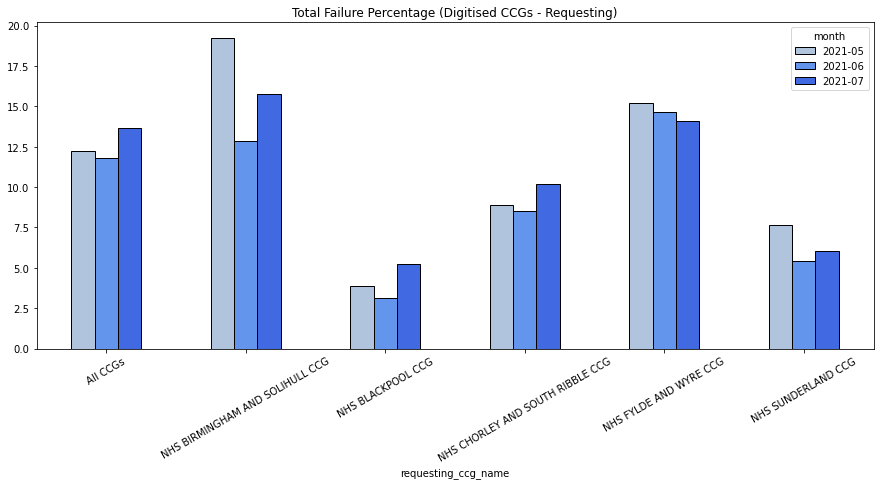

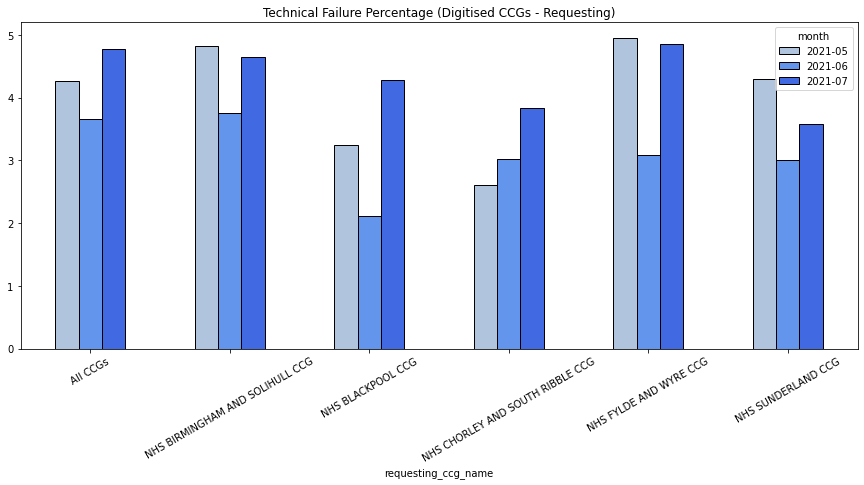

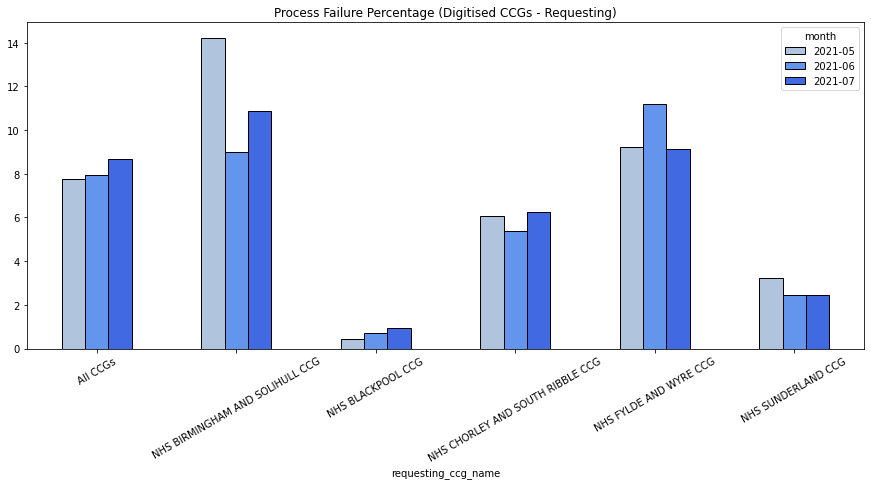

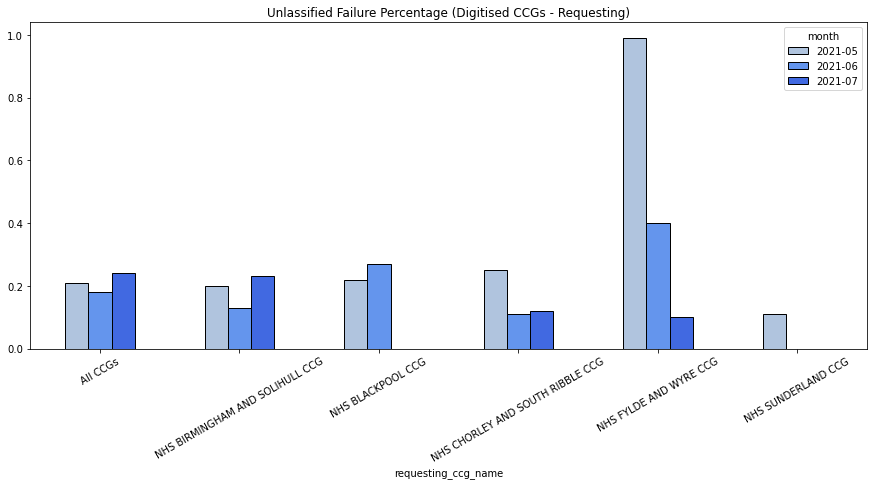

In [11]:
def requesting_ccg_barplot(column_name, title):
    (
        pd
            .concat({'All CCGs': national_metrics_monthly}, names=['requesting_ccg_name'])
            .append(requesting_ccgs_monthly)
            .unstack()
            .plot(
                y=column_name,
                title=title,
                **barplot_config
            )
    )

requesting_ccg_barplot('ALL_FAILURE %', 'Total Failure Percentage (Digitised CCGs - Requesting)')
requesting_ccg_barplot('TECHNICAL_FAILURE %', 'Technical Failure Percentage (Digitised CCGs - Requesting)')
requesting_ccg_barplot('PROCESS_FAILURE %', 'Process Failure Percentage (Digitised CCGs - Requesting)')
requesting_ccg_barplot('UNCLASSIFIED_FAILURE %', 'Unlassified Failure Percentage (Digitised CCGs - Requesting)')

## Looking at failure rate trends by CCG when sending a record

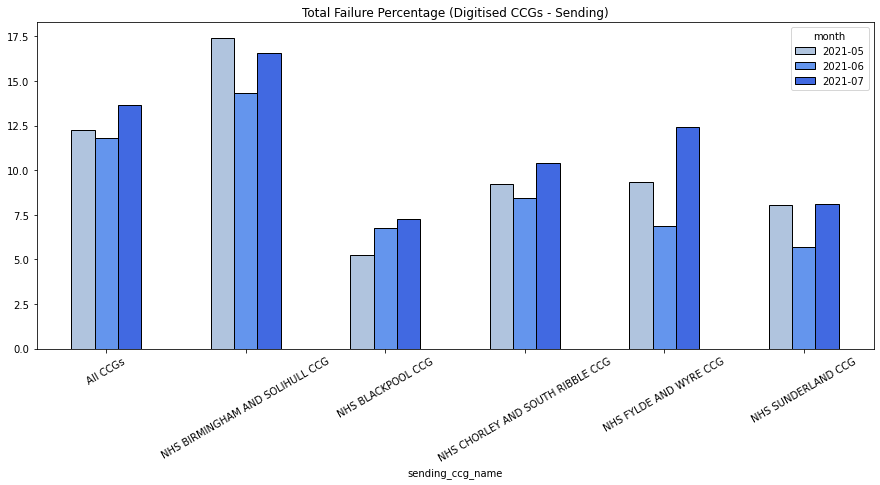

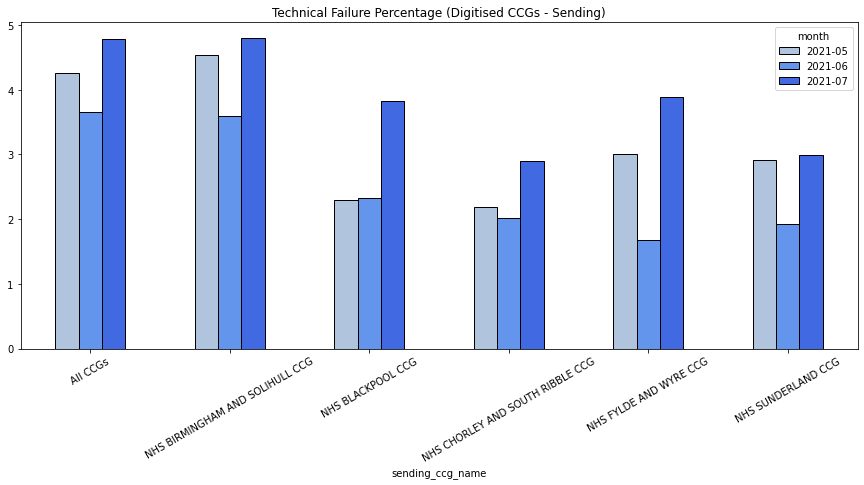

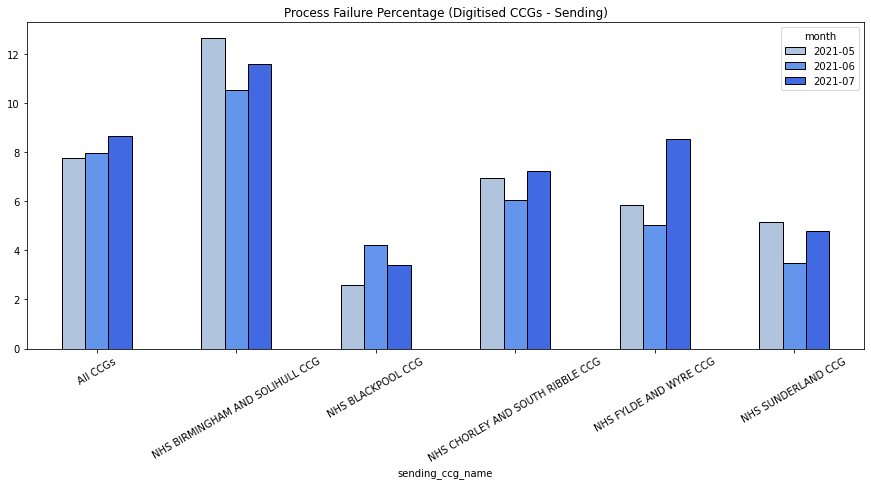

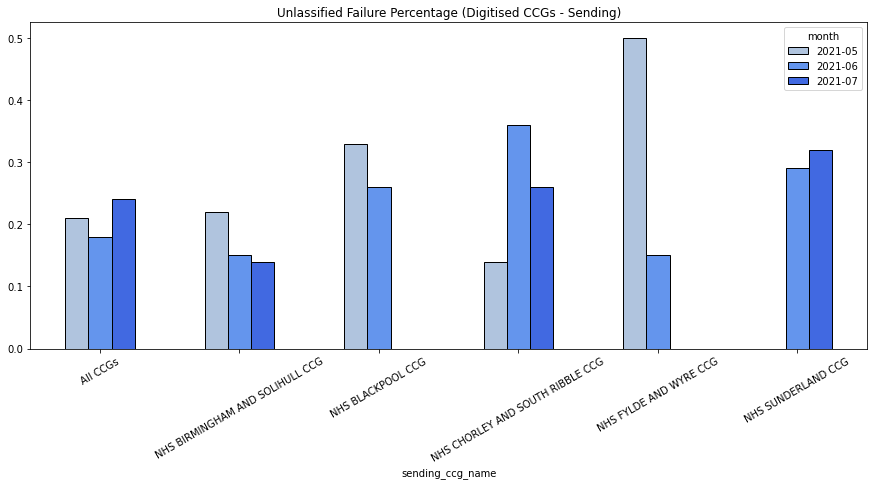

In [12]:
def sending_ccg_barplot(column_name, title):
    (
        pd
            .concat({'All CCGs': national_metrics_monthly}, names=['sending_ccg_name'])
            .append(sending_ccgs_monthly)
            .unstack()
            .plot(
                y=column_name,
                title=title,
                **barplot_config
            )
    )

sending_ccg_barplot('ALL_FAILURE %', 'Total Failure Percentage (Digitised CCGs - Sending)')
sending_ccg_barplot('TECHNICAL_FAILURE %', 'Technical Failure Percentage (Digitised CCGs - Sending)')
sending_ccg_barplot('PROCESS_FAILURE %', 'Process Failure Percentage (Digitised CCGs - Sending)')
sending_ccg_barplot('UNCLASSIFIED_FAILURE %', 'Unlassified Failure Percentage (Digitised CCGs - Sending)')

## Write CCG transfer outcomes by sending and requesting practice to Excel

In [13]:
with pd.ExcelWriter('PRMT-2332-Digitisation-Failure-Rates-May-July-2021.xlsx') as writer:
    national_metrics_monthly.to_excel(writer, sheet_name="National Baseline")
    requesting_ccgs_monthly.to_excel(writer, sheet_name="Digitised CCGs (Req)")
    sending_ccgs_monthly.to_excel(writer, sheet_name="Digitised CCGs (Send)")
    requesting_practices_monthly.to_excel(writer, sheet_name="Digitised Practices (Req)")
    sending_practices_monthly.to_excel(writer, sheet_name="Digitised Practices (Send)")